In [1]:
# Establece las librerias del sistema
# Manejo de datos
import pandas as pd
import numpy as np
# Maejo de directorios y archivos
import os
import glob
# Librerias de pronotiscos
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.seasonal import seasonal_decompose
# Advertencias del sistema
import warnings
warnings.filterwarnings('ignore')



# Funciones internas
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def wmape(actual, forecast):
    actual,forecast = np.array(actual), np.array(forecast)
    se_mape = np.abs(actual-forecast)/actual
    ft_actual_sum = np.sum(actual)
    se_actual_prod_mape = actual * se_mape
    ft_actual_prod_mape_sum = np.sum(se_actual_prod_mape)
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    return ft_wmape_forecast * 100

In [ ]:

categoria =  'CarnicosData'
vista = categoria + "-ini"
path = ( categoria +  '.xlsx')
xl = pd.ExcelFile(path)
fecha_inicio = '2020-03-02'
pproyeccion = 72
print(xl.sheet_names)


df0 = xl.parse('dts')
df1= pd.DataFrame(df0)


dir_actual = os.getcwd()

Pais = "Carnico-Periodo-6MesesHolt"

path = os.path.join(dir_actual, Pais)
path2 = os.path.join(dir_actual, Pais,"reportes")
pathc = os.path.join(dir_actual, Pais,"reportes","Chorizo")
paths = os.path.join(dir_actual, Pais,"reportes","Salchicha")
try:
    os.mkdir(path)
    os.mkdir(path2)
    os.mkdir(pathc)
    os.mkdir(paths)
except:
  print("An exception occurred")


In [ ]:
e1 = pd.pivot_table(df1, values='Cantidad', index=['Fecha'],columns=['Linea'], aggfunc=np.sum)
tpath = os.path.join(path,"Lineas.xlsx")
e1['Periodo'] = pd.date_range(start="2/02/2020", periods=e1.shape[0], freq="W")
print(tpath)
e1.to_excel(tpath)

print(e1)


In [ ]:
"""
Generalmente de aqui en adelante, las variables que terminan en s se refieren a salchichas y en c a chorizos
"""


dfc = df1[(df1.Linea == 'Chorizo y Variedades')]
dfs = df1[(df1.Linea == 'Salchicha')]
e2c = pd.pivot_table(dfc, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum, margins=True,margins_name="Total")
e2s = pd.pivot_table(dfs, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum,margins=True,margins_name="Total")
#Copia el dataframe para rellenar con menor sesgo posteriormente
#Chorizos
e2cn = e2c.copy(deep=True)
Ntotalc =e2c["Total"]/e2c["Total"].loc["Total"]
e2cn.iloc[0:155] = e2c.loc["Total"]
e2c["NTotal"] = Ntotalc
e2cn = e2cn.multiply(e2c["NTotal"], axis = "index")
#Salchichas
e2sn = e2s.copy(deep=True)
Ntotals =e2s["Total"]/e2s["Total"].loc["Total"]
e2sn.iloc[0:155] = e2s.loc["Total"]
e2s["NTotal"] = Ntotals
e2sn = e2sn.multiply(e2s["NTotal"], axis = "index")

spath = os.path.join(path,"CenDis_Salchicha_Procesado.xlsx")
cpath = os.path.join(path,"CenDis_Chorizo_Procesado.xlsx")
#Rellena dt con los datos de menor sesgo
e2c = e2c.fillna(e2cn)
e2s= e2s.fillna(e2sn)


e2c.to_excel(cpath)
e2s.to_excel(spath)

In [ ]:
cdlist = df1["Centro Distribución"].unique()
pivotlistc = {}
pivotlists = {}
pivotlistc2 = {}
pivotlists2 = {}
#Crea las tablas pivote de material por centro de distribucion
for Cd in cdlist:
    dfccd = dfc[(dfc["Centro Distribución"] == Cd)]
    dfscd = dfs[(dfs["Centro Distribución"] == Cd)]

    e3c = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3s = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3c2 = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    e3s2 = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    pivotlistc[Cd]=(e3c)
    pivotlists[Cd]=(e3s)
    pivotlistc2[Cd]=(e3c2)
    pivotlists2[Cd]=(e3s2)
print(pivotlists["NN18"])


In [ ]:
sframe = pd.DataFrame()
cframe = pd.DataFrame()
#Dataframe de las categorias
cframe.index = ['A','B','C']
sframe.index = ['A','B','C']
dfproyeccioness = {}
dfproyeccionesc = {}
matstoprojects = {}
matstoprojectc = {}

def categoria(x):
    if x == 100:
        return 'A'
    elif x >= 90:
        return 'B'
    elif x < 90 or x is None:
        return 'C'

def matrizsesgo(x2,rows):
    xn = x2.copy(deep=True)

    Ntotalc =x2["Total"]/x2["Total"].loc["Total"]
    xn.iloc[0:rows] = xn.loc["Total"]
    x2["NTotal"] = Ntotalc
    xcn = xn.multiply(x2["NTotal"], axis = "index")
    return xcn

for cd in cdlist:
    df2 = pivotlistc[cd]
    df2t = pivotlistc2[cd]
    rowsch = df2t.shape[0]
    mirrorc = matrizsesgo(df2t,rowsch)
    #Cuenta los datos no vacios, convierte a porcentaje y categoriza
    df3 = df2.count()
    df3 = df3.divide(155).multiply(100)
    df3a= df3.apply(categoria)
    aprovedc = df3a[df3a == "A"]
    aprovedc = list(aprovedc.index.values)
    matstoprojectc[cd] = aprovedc
    df3a=df3a.value_counts()
    cframe[cd] = df3a

    df4 = pivotlists[cd]
    df4t = pivotlists2[cd]
    rowssal = df4t.shape[0]
    mirrors = matrizsesgo(df4t,rowssal)
    df5 = df4.count()
    df5 = df5.divide(155).multiply(100)
    df5a= df5.apply(categoria)
    aproveds = df5a[df5a == "A"]
    aproveds = list(aproveds.index.values)
    matstoprojects[cd] = aproveds
    df5a=df5a.value_counts()
    sframe[cd] = df5a

    df2.fillna(mirrorc, inplace=True)
    df4.fillna(mirrors, inplace=True)
    dfproyeccionesc[cd] = df2
    dfproyeccioness[cd] = df4

spath = os.path.join(path,"Reporte_Salchichas ABC.xlsx")
cpath = os.path.join(path,"Reporte_Chorizos ABC.xlsx")
#Guarda el reporte en excel
print(sframe)
print(cframe)
sframe.to_excel(spath, index_label="Periodo")
cframe.to_excel(cpath, index_label="Periodo")
print("Termino")

In [ ]:
errores = []

def Proyeccion(cd,columnName,df3,periodos,ptrend,pseasonal,pdamped,puse,tipo):
        df10 = df3[df3[columnName] > 0]
        df10 = df10[['Periodo', columnName]]
        df10 = df10.set_index('Periodo')
     
        #df10.plot(figsize=(12, 5))
        # Analisis de descomposicion
        #components = seasonal_decompose(df10, period=8)
        #components.plot()
        # Proyeccion
        fit1 = Holt(df10,exponential=True,damped_trend=pdamped,initialization_method="estimated").fit()
        #print(fit1.summary())
        # Calcula el intervalo de confianza al 95% y lo salva
        xhat = fit1.forecast(steps= pproyeccion)
        z = 1.96
        sse = fit1.sse
        predint_xminus = xhat - z * np.sqrt(sse/len(df10))
        predint_xplus  = xhat + z * np.sqrt(sse/len(df10))

        df = [predint_xminus,predint_xplus]
        df = pd.DataFrame(df)
        df = df.transpose()
        col0 = columnName + "_minimo"
        col1 = columnName + "_maximo"

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)

        # Salva los intervalos

        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+vista + '-_intervalo_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        #df.to_excel(dirPath, index_label="Periodo")


        # Intervalo de confianza por simulacion
        simulations = fit1.simulate(pproyeccion, repetitions=1, error="add", random_errors=None)
        #ax = df10.plot(figsize=(12, 5),marker="o",color="black",title="Proyeccion",)
        #ax.set_ylabel("Venta")
        #ax.set_xlabel("Periodo")
        #fit1.fittedvalues.plot(ax=ax, style="--", color="green")
        #fit1.forecast(steps=pproyeccion).rename("Proyeccion").plot(ax=ax, style="--", marker="o", color="green", legend=True )


        # Grafica la serie de Ajuste y la añade a fit1
        df6 = fit1.forecast(pproyeccion)
        df6.plot()
        df7 = fit1.predict(0)

        df8 = [df7,df6]

        #df1 = (df0[[columnName]])

        df = pd.DataFrame(df8)
        df = df.transpose()
        col0 = columnName + "_ajuste"
        col1 = columnName + "_proyeccion"
        col2 = columnName 

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)
        df = df.fillna(0)
        df[col2] = df[col1].add(df10[columnName],fill_value=0)
        # Salva la proyeccion normal
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-py_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")

        # Calcula el Error por medio del MAPE, lo guarda en un diccionario
        df99 = [df7]
        yy = pd.DataFrame(df99)
        yy = yy.transpose()
        xx = pd.DataFrame(df10)
        errores.append({"cd":cd+"-"+tipo+"-"+columnName,"Mape":mape(xx,yy),"wmape":wmape(xx,yy),"tipo":tipo})

def Procesamiento(df,cd,tipo):
    for (columnName, columnData) in df.items():
        #print('Column Name : ', columnName)
        #print('Column Contents : ', columnData.values)
        # Parametros personalizados
        ptrend = False
        pseasonal = 'add'
        pdamped = False
        puse = 0.7
        periodos = 24

        if (columnName != 'Periodo') :
           try:
                Proyeccion(cd,columnName,df,periodos,ptrend,pseasonal,pdamped,puse,tipo)
           except:
                Proyeccion(cd,columnName,df,4,ptrend,pseasonal,pdamped,puse,tipo)


for cd in cdlist:

    totalcds = e2s[cd]
    totalcds = totalcds.drop("Total")
    totalcdc = e2c[cd]
    totalcdc = totalcdc.drop("Total")



    dfps2 = dfproyeccioness[cd]
    dfps2 = dfps2.loc[:, dfps2.columns.isin(matstoprojects[cd])]
    dfps2['Total'] = totalcds
    #Crea las semanas para la proyeccion, si no las genera pandas no hace el pronostico correctamente
    dfps2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfps2.shape[0], freq="W")
    dfps2.to_excel(cd +"test.xlsx", index_label="Periodo")
    Procesamiento(dfps2,cd,"Salchicha")

    dfpc2 = dfproyeccionesc[cd]
    dfpc2 = dfpc2.loc[:, dfpc2.columns.isin(matstoprojectc[cd])]
    dfpc2['Total'] = totalcdc
    dfpc2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfpc2.shape[0], freq="W")
    dfpc2.to_excel(cd +"testc.xlsx", index_label="Periodo")
    Procesamiento(dfpc2,cd,"Chorizo")
    dferrores = pd.DataFrame(errores)
print("terminado") 


In [8]:
#Errores a excel:
mdir2 = os.path.join(dir_actual, Pais,"reportes")
mfilac = vista + '-CentroDistribucion-Chorizos-Errores.xlsx'
dirPathc = os.path.join(mdir2, mfilac)
mfilas = vista + '-CentrosDistribucion-Salchichas-Errores.xlsx'
dirPaths = os.path.join(mdir2, mfilas)
print(dferrores)
dfes = dferrores[dferrores["tipo"]== "Salchicha"]
dfec = dferrores[dferrores["tipo"]== "Chorizo"]
dfes.to_excel(dirPaths)
dfec.to_excel(dirPathc)

# Une la salida

for cd in cdlist:
    for tipo in ["Salchicha","Chorizo"]:
        df=[]

        mdir = os.path.join(dir_actual, Pais)
        mfila = os.path.join(mdir, cd +"-"+tipo+"-"+ vista + "-py*")
        files = glob.glob(mfila)
        #print(mfila)
        for a in files:
            df.append( pd.read_excel(a, sheet_name='Sheet1'))

        i = 0
        for x in df:
            if i > 0 :
                dt = pd.merge(dt, df[i])
            else :
                dt = df[0]
            i = i + 1
       
        # Salva la proyeccion final de cada serie
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-Reporte_Final.xlsx'
        dirPath = os.path.join(mdir2,tipo, mfila)
        dt= dt.set_index('Periodo')
        dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
        dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
        dt2= dt.iloc[:, :-1].sum(axis=1)
        dt['A'] = dt2
        dt['B+C'] = dt['Total'] - dt['A']
        dt.insert(0, 'B+C', dt.pop('B+C'))
        dt.insert(0, 'A', dt.pop('A'))

        dt.to_excel(dirPath)

      

                          cd       Mape      wmape       tipo
0    NN13-Salchicha-M1000497  16.847256  16.264714  Salchicha
1    NN13-Salchicha-M1000794  18.335172  17.797634  Salchicha
2    NN13-Salchicha-M1000820  15.764472  14.748820  Salchicha
3    NN13-Salchicha-M1000821   8.762798   8.643186  Salchicha
4    NN13-Salchicha-M1000833  16.917930  15.929962  Salchicha
..                       ...        ...        ...        ...
345  NNB8-Salchicha-M1043327  10.045835   9.613073  Salchicha
346  NNB8-Salchicha-M1043643  11.281427  10.437927  Salchicha
347  NNB8-Salchicha-M1046292   6.822359   6.889330  Salchicha
348     NNB8-Salchicha-Total   8.757451   8.645522  Salchicha
349       NNB8-Chorizo-Total  12.156335  11.053977    Chorizo

[350 rows x 4 columns]


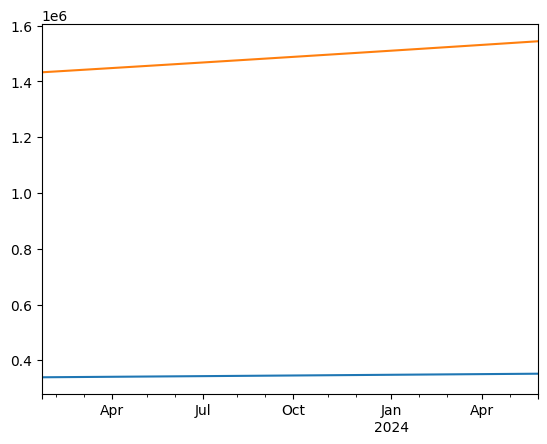

In [9]:
Procesamiento(e1,"Lineas","Proyeccion")
df=[]

mdir = os.path.join(dir_actual, Pais)
mfila = os.path.join(mdir, "Lineas-Proyeccion-CarnicosData-ini-py*")
files = glob.glob(mfila)
#print(mfila)
for a in files:
    df.append( pd.read_excel(a, sheet_name='Sheet1'))

i = 0
for x in df:
    if i > 0 :
        dt = pd.merge(dt, df[i])
    else :
        dt = df[0]
    i = i + 1
       
# Salva la proyeccion final de cada serie
mdir = os.path.join(dir_actual, Pais)
mfila = 'Lineas-Proyeccion-CarnicosData-Reporte_Final.xlsx'
dirPath = os.path.join(mdir, mfila)
dt= dt.set_index('Periodo')
dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
dt.to_excel(dirPath)

In [10]:
dfes

,cd,Mape,wmape,tipo
0,NN13-Salchicha-M1000497,16.847256,16.264714,Salchicha
1,NN13-Salchicha-M1000794,18.335172,17.797634,Salchicha
2,NN13-Salchicha-M1000820,15.764472,14.748820,Salchicha
3,NN13-Salchicha-M1000821,8.762798,8.643186,Salchicha
4,NN13-Salchicha-M1000833,16.917930,15.929962,Salchicha
...,...,...,...,...
344,NNB8-Salchicha-M1035365,24.221285,20.898804,Salchicha
345,NNB8-Salchicha-M1043327,10.045835,9.613073,Salchicha
346,NNB8-Salchicha-M1043643,11.281427,10.437927,Salchicha
347,NNB8-Salchicha-M1046292,6.822359,6.889330,Salchicha
